In [1]:
import pandas as pd
import numpy as np
import re
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
custom_stopwords = {
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your",
    "yours", "yourself", "yourselves",
    "he", "him", "his", "himself", "she", "her", "hers", "herself", "it",
    "its", "itself", "they", "them", "their",
    "theirs", "themselves", "what", "which", "who", "whom", "this", "that",
    "these", "those", "am", "is", "are", "was",
    "were", "be", "been", "being", "have", "has", "had", "having", "do",
    "does", "did", "doing", "a", "an", "the", "and",
    "but", "if", "or", "because", "as", "until", "while", "of", "at", "by",
    "for", "with", "about", "against", "between",
    "into", "through", "during", "before", "after", "above", "below", "to",
    "from", "up", "down", "in", "out", "on", "off",
    "over", "under", "again", "further", "then", "once", "here", "there",
    "when", "where", "why", "how", "all", "any", "both",
    "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not",
    "only", "own", "same", "so", "than", "too", "very",
    "s", "t", "can", "will", "just", "don", "should", "now", "d", "ll", "m",
    "o", "re", "ve", "y", "ain", "aren", "couldn", "didn",
    "doesn", "hadn", "hasn", "haven", "isn", "ma", "mightn", "mustn", "needn",
    "shan", "shouldn", "wasn", "weren", "won", "wouldn"
}

In [3]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"


In [9]:
def confusion_matrix(y_test, y_pred):

    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["non-cyberbullying", "cyberbullying"])
    plt.yticks(tick_marks, ["non-cyberbullying", "cyberbullying"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i, j] > cm.max() / 2 else "black")

    plt.show()


In [5]:
def clean_text(text):

    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words_to_filter = text.split()
    # words_to_filter = [word for word in words if word.lower() not in \
    #                                         words_to_remove]

    words_to_filter = ' '.join(words_to_filter)
    return words_to_filter

In [6]:
def preprocess_data(df):

    types_of_CB = ["religion", "age", "other_cyberbullying", "ethnicity","gender"]

    # Check for missing values
    missing_values = df.isna().sum()
    print(f'Missing Values:\n{missing_values}')

    # Find all tweets that are less than 2 character in length and remove them
    df['tweet_length'] = [len(text.split()) for text in df.tweet_text]
    df = df.loc[df['tweet_length'] >= 2]
    df.drop('tweet_length', axis=1, inplace=True)

    # Clean the text by removing special characters and converting all text to lower case
    df['tweet_text'] = df['tweet_text'].apply(clean_text)

    # Manually encode the different types of cyberbullying/non-cyberbullying
    df.loc[df['cyberbullying_type'].isin(types_of_CB), 'cyberbullying_type']= 0

    df.loc[df['cyberbullying_type'] == 'not_cyberbullying','cyberbullying_type'] = 1

    # Ensure target column is of type int
    df['cyberbullying_type'] = df['cyberbullying_type'].astype(int)

    # Check Unique y values
    y_values = df['cyberbullying_type'].value_counts()
    print(f'Check y values and counts \n {y_values}')

    return df
    # filter out any non-english tweets
    # df_resize['language'] = df_resize['tweet_text'].apply(detect_language)
    # df_english = df[df['language'] == 'en']

Missing Values:
tweet_text            0
cyberbullying_type    0
dtype: int64


/Users/admin/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-6-3f32df8c5d79>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tweet_text'] = df['tweet_text'].apply(clean_text)
/Users/admin/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

Check y values and counts 
 0    39596
1     7892
Name: cyberbullying_type, dtype: int64
                                          tweet_text  cyberbullying_type
0  in other words katandandre your food was crapi...                   1
1  why is aussietv so white mkr theblock imaceleb...                   1
2  xochitlsuckkks a classy whore or more red velv...                   1
3  jasongio meh p thanks for the heads up but not...                   1
4  rudhoeenglish this is an isis account pretendi...                   1
Unique y test data [0 1]
Unique y train data [1 0]
Training Complete
Accuracy:  0.848494419877869


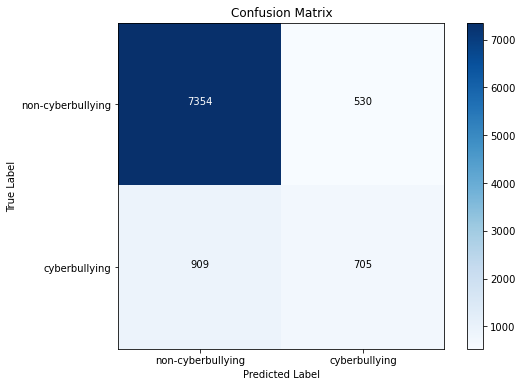

In [10]:
def main():
    df = pd.read_csv("cyberbullying_tweets.csv")

    df = preprocess_data(df)

    # Look at the data
    print(df.head())

    # X is the features (the input data)
    X = df['tweet_text']

    # y is the targets (output or label)
    y = df['cyberbullying_type']

    # Create features based on n-grams in corpus
    vectorized_features = CountVectorizer(ngram_range=(1, 3))

    X_ngram = vectorized_features.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_ngram,
                                                        y, test_size=0.2,
                                                        random_state=42)

    print("Unique y test data", y_test.unique())
    print("Unique y train data", y_train.unique())

    SVM = svm.SVC(kernel='linear', decision_function_shape='ovr')

    SVM.fit(X_train, y_train)

    y_pred = SVM.predict(X_test)

    print("Training Complete")
    print(f'Accuracy: ', metrics.accuracy_score(y_test, y_pred))

    # Print confusion matrix
    confusion_matrix(y_test, y_pred)

# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    main()